<a href="https://colab.research.google.com/github/C-Designer/Codestates_project/blob/main/Section1_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [263]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns   #색상 지정
import pandas as pd
import numpy as np
import scipy.stats
import math

%matplotlib inline
mpl.rc('axes', unicode_minus=False)
plt.rc('font', family='NanumBarunGothic') 
%config InlineBackend.figure_format='retina'

## 데이터 전처리
- 결측값 처리
- 금액단위 통합
- 날짜값 이상치 처리

#### 결측값 처리

In [264]:
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv').iloc[:, 1:]

df.isna().sum() # 무작위 결측(MAR)

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

Text(0.5, 1.0, 'Total Missing Value (%)')

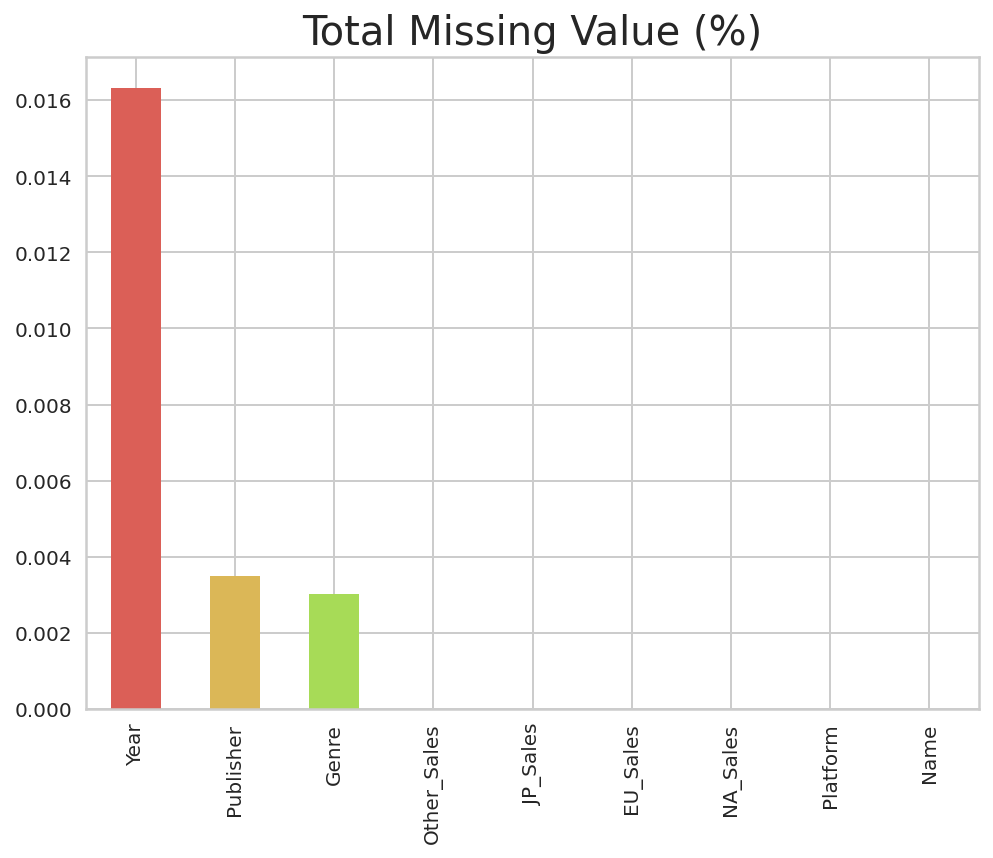

In [265]:
colors = sns.color_palette('hls', 9) #색상 지정
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10, color = colors)

plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

Text(0.5, 1.0, 'Correlation with Missing Values')

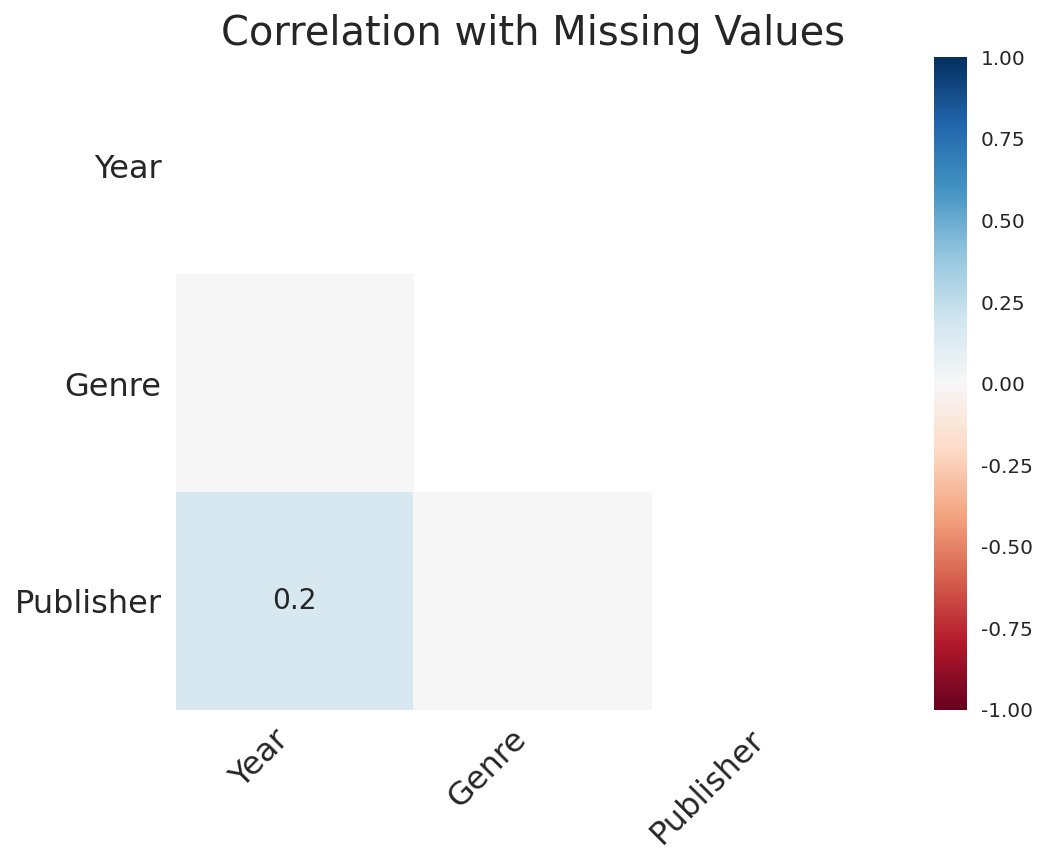

In [266]:
import missingno as msno

missingdata_df = df.columns[df.isnull().any()].tolist()
msno.heatmap(df[missingdata_df], figsize=(8,6))
plt.title("Correlation with Missing Values", fontsize = 20)

In [267]:
df[df['Year'].isnull()]  # 관측치인 결측값중 동일한 기준이 없어 합리적 접근이 불가하다.
df[df['Publisher'].isnull()].head()
df[df['Genre'].isnull()].head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
50,Ape Escape: On the Loose,PSP,2005.0,NaN,Sony Computer Entertainment,0.52,0.01,0.12,0.05
408,NBA Ballers,XB,2004.0,NaN,Midway Games,0.37,0.11,0,0.02
1328,NFL Street,XB,2004.0,NaN,Electronic Arts,0.49,0.15,0,0.02
1582,SingStar Singalong With Disney,PS2,2008.0,NaN,Sony Computer Entertainment,0,0.04,0,0.57
1971,Pokemon X/Pokemon Y,3DS,2013.0,NaN,Nintendo,5170K,4.05,4.34,0.79


In [268]:
df = df.dropna()
df.isna().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

#### 금액 단위 통합 - M으로 통합, 1K = 0.001M, M은 제거

In [269]:
def Processing_Amount(sales):  # 금액단위 통합 : 단위 추출안될시 반환값 없음

  l = list(sales)              # 금액단위 제거
  unit = l[len(l) -1]
  del l[len(l) -1]

  if unit == 'K':              # 단위가 있을경우 금액 재추출
    sales = float(''.join(l)) * 0.001
  elif unit == 'M':
    sales = float(''.join(l))

  return float(sales) * 1000

In [270]:
sales = (df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
         .applymap(Processing_Amount)
         .astype('int')
         )

df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']] = sales

df['Sum_Sales'] = sales.T.sum()
df = df.fillna(0)
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sum_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40,0,0,0,40
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,170,0,0,10,180
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,20,0,20
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,40,0,0,0,40
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,120,90,0,40,250
...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,150,40,0,10,200
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,10,0,0,0,10
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,440,190,30,130,790
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,50,50,250,30,380


#### 날짜값 이상치 처리
연도 기준의 표준편차<br>
연도별 - 2자리수 이하 21년을 기준으로 21 이하일시 +2000 / 21 초과일시 +1900

In [271]:
def Processing_Year(year):
  if year < 100:
    if year > 21:
      year += 1900
    else:
      year += 2000
  
  return year

In [272]:
pd.DataFrame(df['Year'].sort_values().head(110)).T

,9276,16394,14666,2249,8681,11163,15612,8144,8912,8509,768,8765,4800,1220,5314,15260,14161,2548,15442,4746,12636,11236,2467,7055,2454,10406,8583,1364,3746,7600,12495,9080,3879,6130,16103,3108,16149,8928,15511,7178,...,12382,10811,10922,8550,6899,4727,5193,7555,304,7184,15836,8191,11263,6192,15447,4010,4365,15985,4807,4839,14785,11334,906,10705,2429,81,10315,14572,16482,3492,15012,7317,14264,13133,9226,5723,5938,10121,5072,5320
Year,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,7.0,7.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,12.0,12.0,13.0,13.0,14.0,14.0,15.0,15.0,15.0,15.0,15.0,16.0,16.0,16.0,16.0,16.0,86.0,94.0,95.0,95.0,95.0,95.0,96.0,96.0,96.0,97.0,97.0,98.0,98.0,98.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1981.0,1981.0


In [273]:
pd.DataFrame(df['Year'].apply(Processing_Year).sort_values().head(110)).T

,14264,5723,15012,9226,13133,10121,7317,5938,1060,1308,1565,14006,10987,15885,14984,6122,4106,5320,1655,16472,5072,5483,8608,664,13452,2052,8724,1706,1111,2618,11809,6871,13506,14427,3023,9109,14738,1382,15872,877,...,14316,15429,7813,13548,4933,3000,10125,2792,15477,6521,3552,13361,6567,15215,2519,3910,13358,2661,11259,6252,12191,6104,10570,10657,15283,16363,6892,12322,10081,5169,10658,6499,10825,6027,12921,466,4310,5974,10615,2001
Year,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,...,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1984.0,1984.0,1984.0


In [274]:
df['Year'] = df['Year'].apply(Processing_Year)

In [275]:
df = df.sort_values('Year').reset_index()
del df['index']

## 반드시 들어가야 하는 내용
1. 지역에 따라서 선호하는 게임 장르가 다를까
2. 연도별 게임의 트렌드가 있을까
3. 매출이 높은 게임에 대한 분석 및 시각화 프로세스

#### 지역에 따라서 선호하는 게임 장르
다른 기준선이 없어 선호의 기준은 지역별 매출로 결정

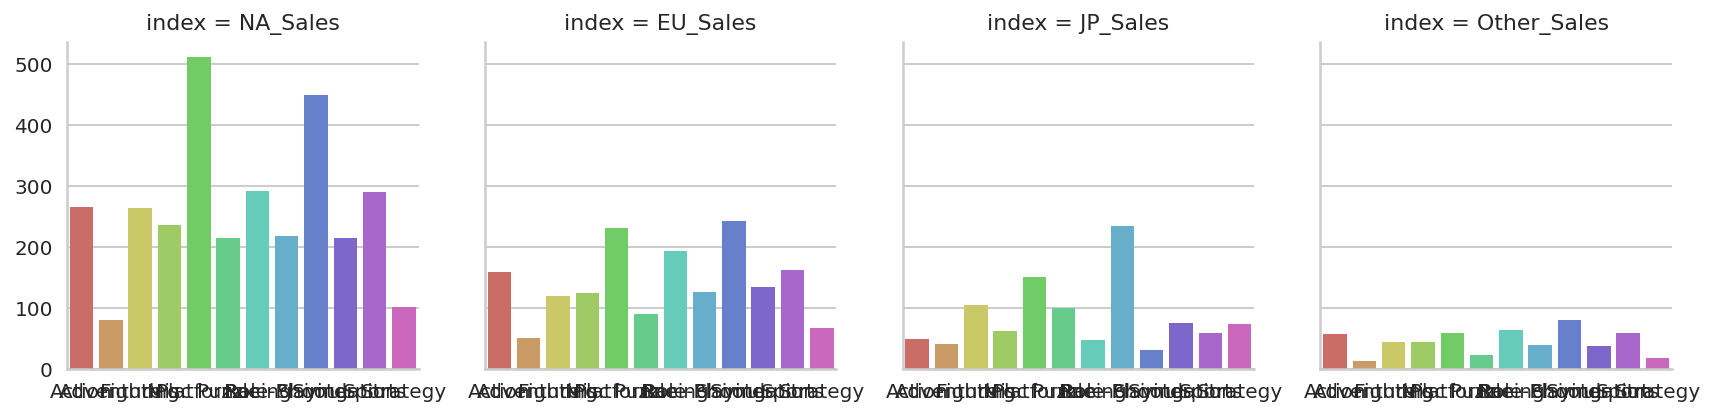

In [276]:
Genre_Sales = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
Genre_Sales = Genre_Sales.groupby('Genre').mean()

location = Genre_Sales.T.reset_index()
colors = sns.color_palette('hls', len(location.T))

g = sns.FacetGrid(data = location, col = 'index') # col이 아니라 row 로도 실행해보세요.

g.map_dataframe(
    sns.barplot,
    palette = colors,
    data = location
)

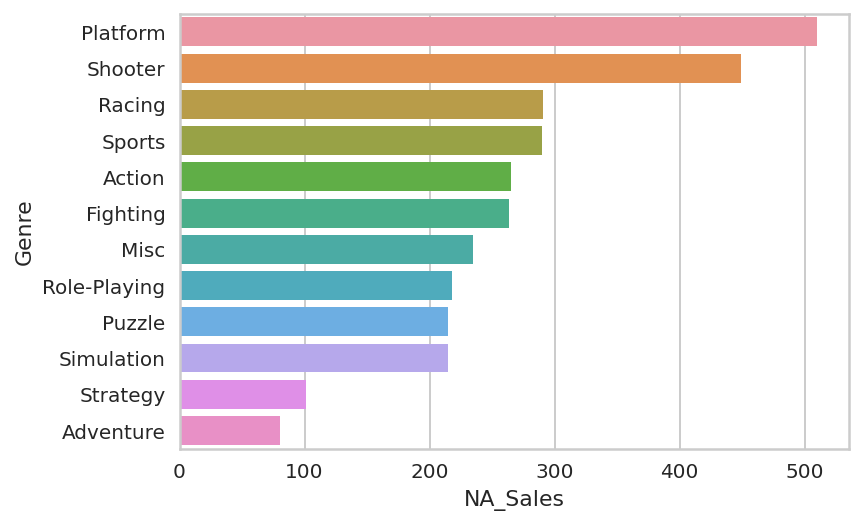

In [277]:
# 북미 매출액
NA_Genre = Genre_Sales['NA_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'NA_Sales', data= NA_Genre)

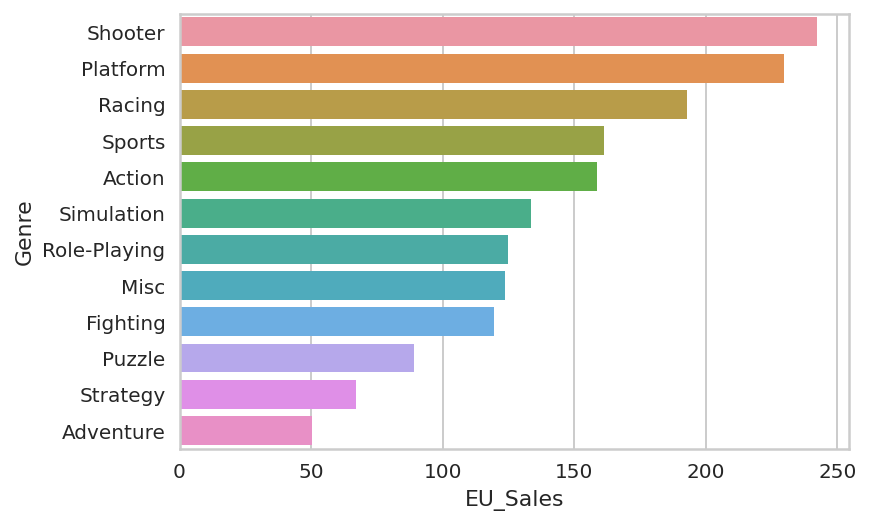

In [278]:
# 유럽 매출액
EU_Genre = Genre_Sales['EU_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'EU_Sales', data= EU_Genre)

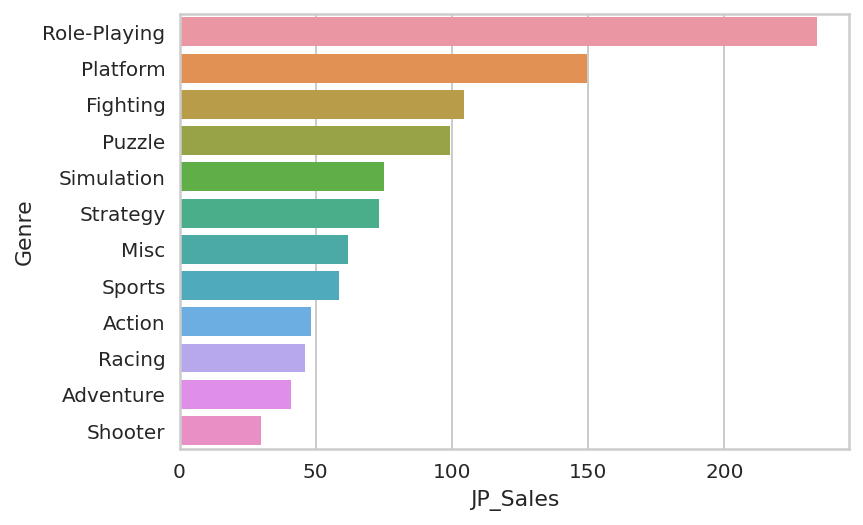

In [279]:
# 일본 매출액
JP_Genre = Genre_Sales['JP_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'JP_Sales', data= JP_Genre)

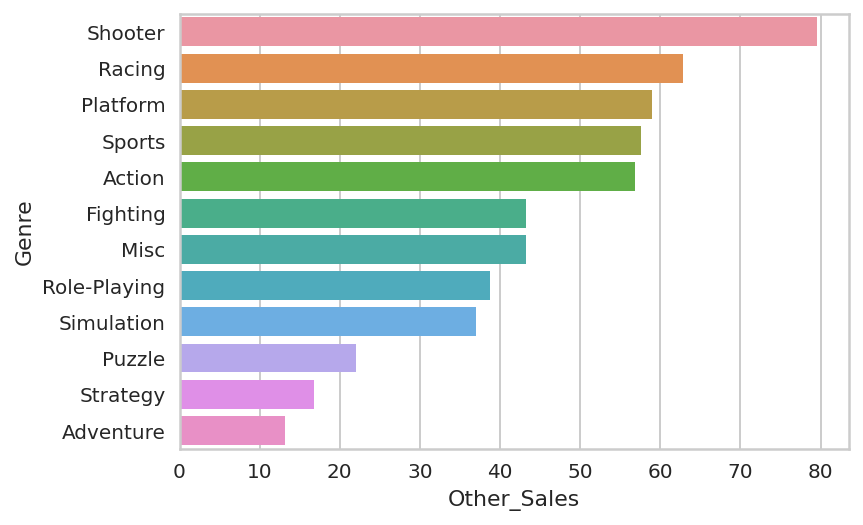

In [280]:
# 기타지역 매출액
Other_Genre = Genre_Sales['Other_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'Other_Sales', data= Other_Genre)

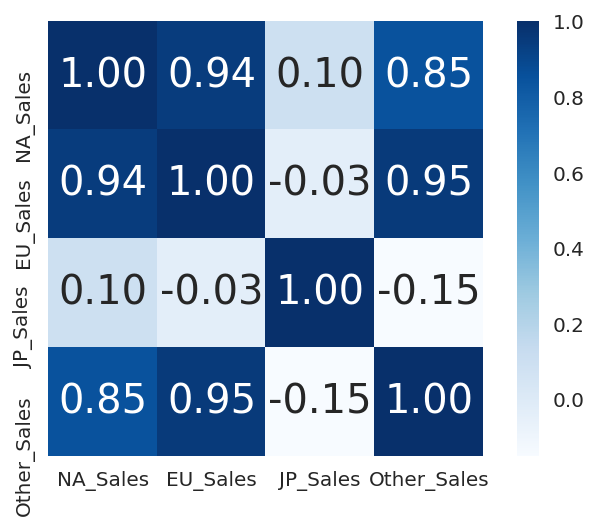

In [281]:
corr = Genre_Sales.corr(method= 'pearson')

sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

#### 연도별 게임의 트렌드
연간 장르별 최다 출시 장르<br>
연간 장르별 매출 합산후 최고매출 장르<br>
연간 장르별 매출평균 중 최고매출 장르

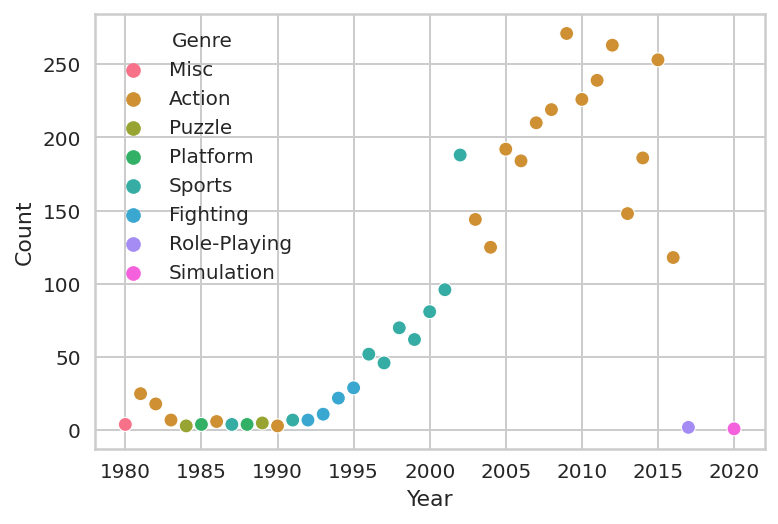

In [282]:
# 연간 게임 최다 출시갯수 장르
trend = df.groupby(['Year', 'Genre']).count().iloc[:, 1]
trend = trend.loc[trend.groupby('Year').idxmax()].to_frame().reset_index()
trend.columns = ['Year', 'Genre', 'Count']

sns.scatterplot(x= 'Year', y= 'Count', hue= 'Genre', data= trend)

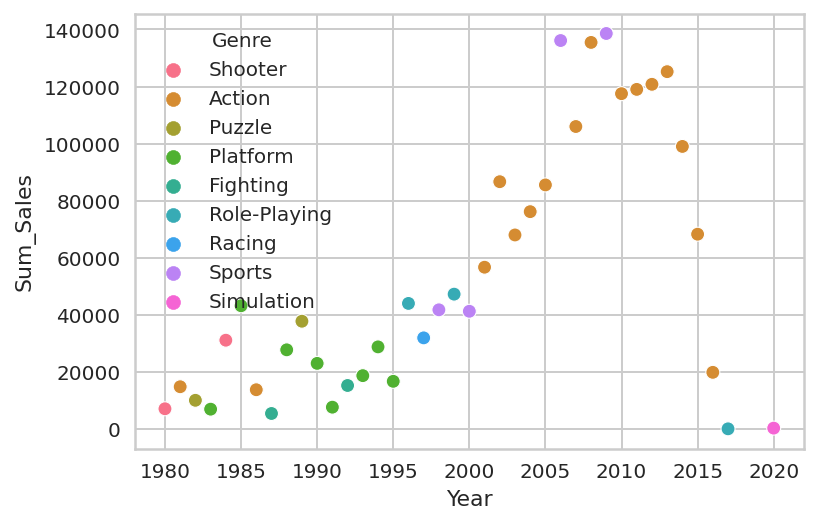

In [283]:
# 연간 장르별 매출 합산후 최고매출 장르
sum = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).sum() # 연도별 장르끼리 합치기
sum = sum.loc[sum.groupby('Year')['Sum_Sales'].idxmax()] # 연도별 매출 가장큰 장르 추출

sns.scatterplot(x= 'Year', y= 'Sum_Sales', hue= 'Genre', data= sum)

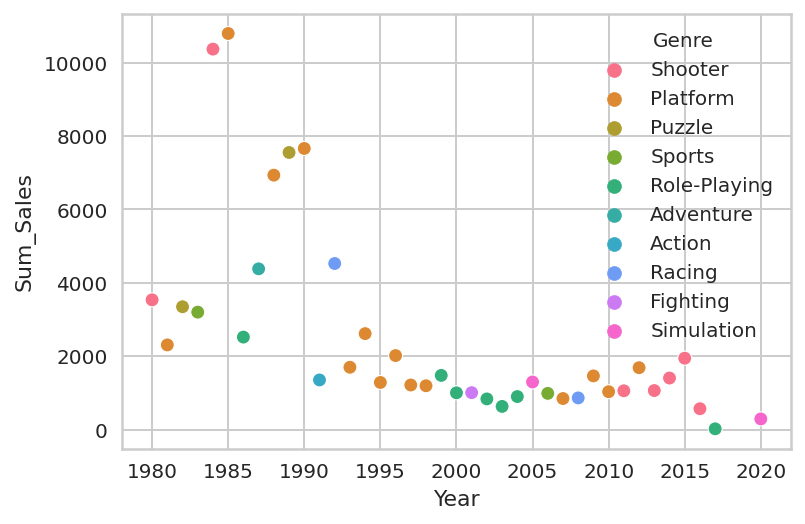

In [284]:
# 연간 장르별 매출평균 중 최고매출 장르
mean = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).mean() # 연도별 장르끼리 합치기
mean = mean.loc[mean.groupby('Year')['Sum_Sales'].idxmax()] # 연도별 매출 가장큰 장르 추출

sns.scatterplot(x= 'Year', y= 'Sum_Sales', hue= 'Genre', data= mean)

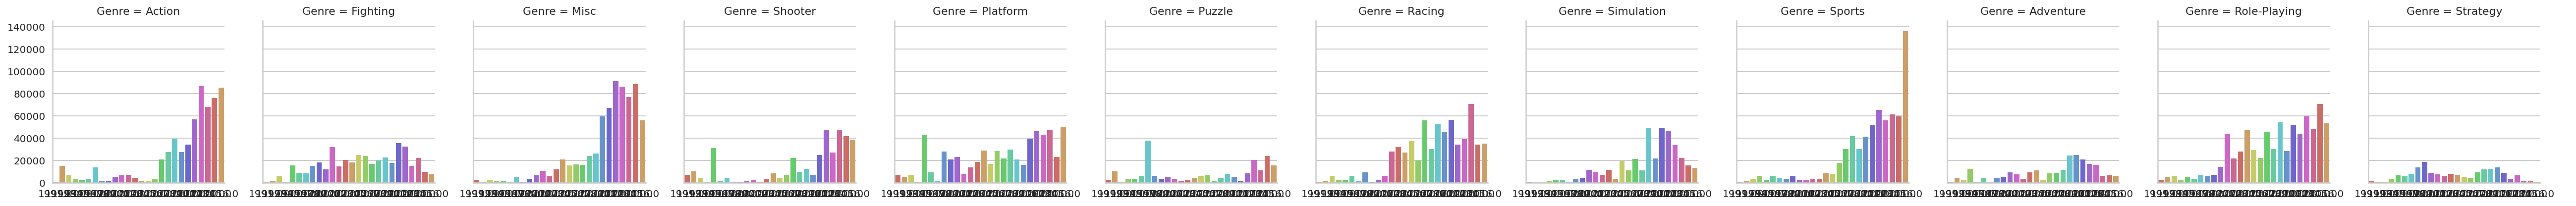

In [285]:
# 장르별 연간 매출

Genre = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).sum().reset_index()

g = sns.FacetGrid(data = Genre, col = 'Genre')
colors = sns.color_palette('hls', len(df['Genre'].unique()))

g.map_dataframe(
    sns.barplot,
    x = 'Year',
    y = 'Sum_Sales',
    data = Genre,
    palette = colors
)
g.add_legend();

#### 매출이 높은 게임에 대한 분석 및 시각화 프로세스

In [286]:
# 매출 상위 1%
top_Game = df.sort_values('Sum_Sales', ascending= False).iloc[:int(len(df) * 0.01)]
top_Game = top_Game[['Platform', 'Genre', 'Publisher', 'Sum_Sales']]
top_Game

,Platform,Genre,Publisher,Sum_Sales
6455,Wii,Sports,Nintendo,82740
129,NES,Platform,Nintendo,40240
8805,Wii,Racing,Nintendo,35830
10664,Wii,Sports,Nintendo,33000
883,GB,Role-Playing,Nintendo,31380
...,...,...,...,...
13029,PS3,Action,Warner Bros. Interactive Entertainment,5520
9288,PSP,Role-Playing,Capcom,5510
2508,GBA,Platform,Nintendo,5490
2475,GBA,Racing,Nintendo,5480


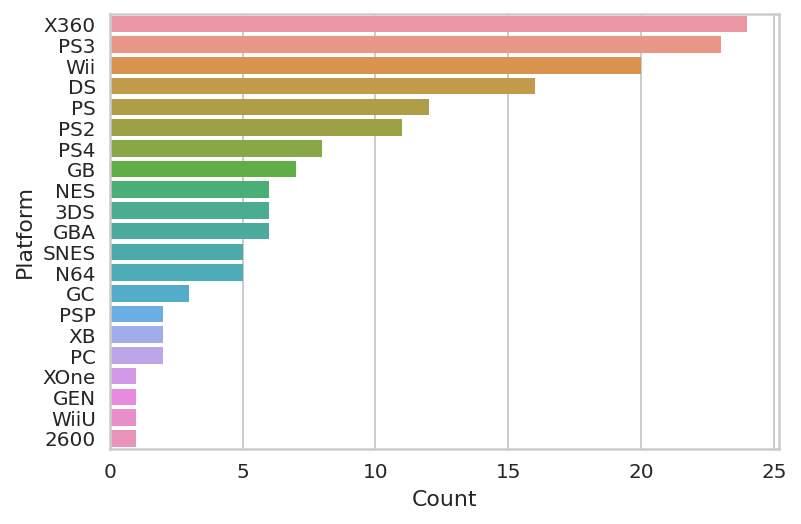

In [287]:
# 상위 1% 플랫폼비율
top_Platform = (top_Game.groupby('Platform').count()  # 카운팅
  .iloc[:, 1]   # 관련없는 열 제거
 .sort_values(ascending= False)  # 내림차순
 .reset_index()
 )

top_Platform.columns = ['Platform', 'Count']

sns.barplot(x= 'Count', y= 'Platform', data= top_Platform)

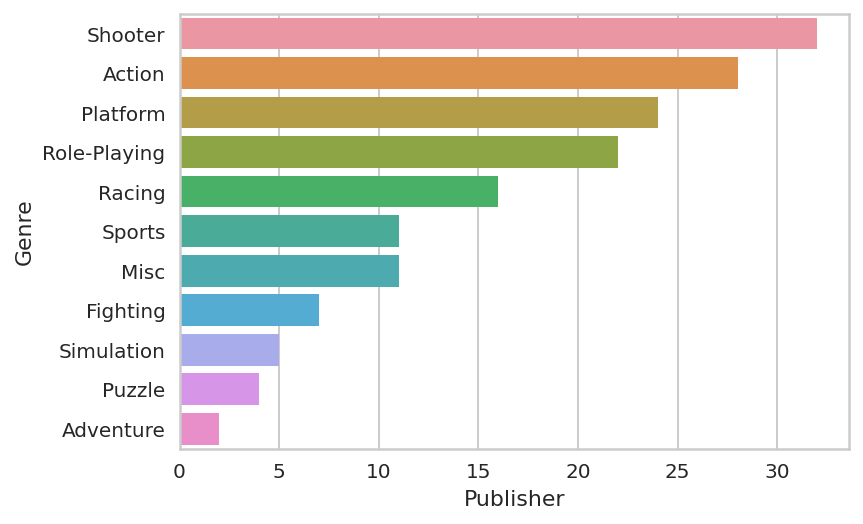

In [288]:
# 상위 1% 장르비율
top_Genre = top_Game.groupby('Genre').count().iloc[:, 1].sort_values(ascending= False).reset_index()

sns.barplot(x= 'Publisher', y= 'Genre', data= top_Genre)

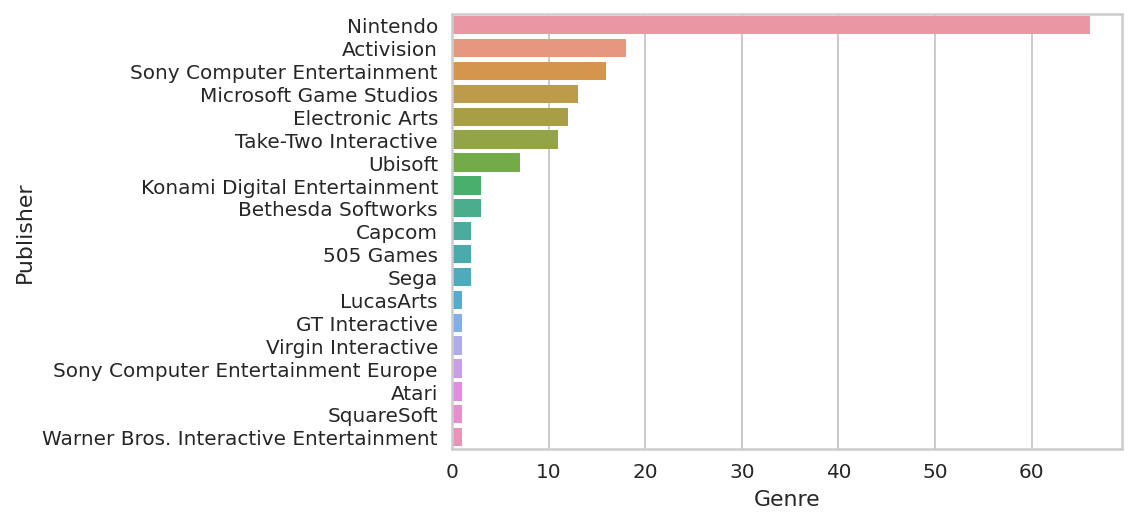

In [289]:
# 상위 1% 퍼블리셔비율
top_Publisher = top_Game.groupby('Publisher').count().iloc[:, 1].sort_values(ascending= False).reset_index()

sns.barplot(x= 'Genre', y= 'Publisher', data= top_Publisher)

## 결과 및 견해
1. 지역에 따라서 선호하는 게임 장르가 다를까<br>
  통계적 수치에 따른 장르별 매출 순위
  - 북미 : Platform, Shooter, Racing ...
  - 유럽 : Shooter, Platform, Racing ...
  - 일본 : Role-Playing, Platform, Fighting ...
  - 기타 : Shooter, Racing, Platform ...

  다르다고 볼수있다. 신기하게도 피어슨 상관계수를 사용하여 상관분석을 해본결과<br>
  일본빼곤 정도의 차이이지 다들 비슷한 결과가 나왔다

2. 연도별 게임의 트렌드가 있을까<br>
  트렌드의 기준을 무엇으로 둬야할지 애매해서 나누어 분석하였다<br>
  - 연간 장르별 최다 출시 장르
  - 연간 장르별 매출 합산후 최고매출 장르
  - 연간 장르별 매출평균 중 최고매출 장르

  2000년을 기점으로 액션장르가 주축을 이루는것으로 보인다

3. 매출이 높은 게임에 대한 분석 및 시각화 프로세스<br>
  매출상위 1%를 기준으로 나열한 순위이다
  - 플랫폼 비율 : x360, PS3, Wii, DS ..
  - 장르 비율 : Shooter, Action, Platform, Role_Playing ..
  - 퍼블리셔 비율 : Nintendo, Activision, Sony .. 


In [290]:
# 최다 출시 장르 및 합산매출 최고매출 장르는 예상한 결과대로 양의 상관관계를 가지는것으로 보인다

x = sum.values
y = trend.iloc[:, 2]

scipy.stats.spearmanr(x, y).correlation

0.8508485615514678

,Genre
Year,
1980.0,8
1981.0,46
1982.0,36
1983.0,17
1984.0,14


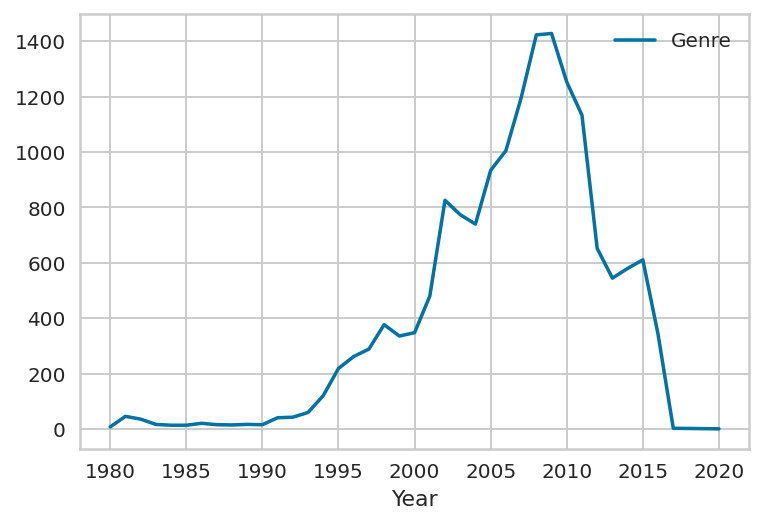

In [291]:
# 연도별 데이터수의 표준편차
from scipy.stats import chisquare

count_by_years = df[['Year', 'Genre']].groupby('Year').count()

count_by_years.plot()
np.std(count_by_years)

df[['Year', 'Genre']].groupby('Year').count().head()

In [293]:
top_Platform = top_Platform.set_index('Platform')

PS = ['PS3', 'PS', 'PS2', 'PS4', ]